**Q1: Why is the KL Divergence term important in the VAE loss function?**

KL divergence measures the closeness of the approximation between two distributions.  This is imperative for a loss function when creating a model that can generate realistic data because the model does so by attempting to recreate the true distribution of the data.  By evaluating the differences in the true and predicted distributions, the model can learn to minimize the KL divergence over time.

**Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?**

When the target of a model is to learn the probabilistic latent distribution such as 𝒩~(μ, σ^2), a model will attempt to replicate this distribution and backpropogate using the gradients from the loss function.  If the target is a distribution though, the function is non-differentiable because a distribution has "randomness" to it and is dependent on μ and σ, so the gradient can not be defined.  By introducing some noise ϵ sampled from a normal distribution, the gradients of μ and σ can be computed in terms of ϵ making them differentiable.  This allows the model to backpropogate and minimize the loss as it models the true distribution.

**Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?**

If a fixed latent space were used, then the VAE would be a one-to-one model, meaning for each input there is a single output.  For instance, if the VAE were trained to generate images from text, the input "dog" would generate the same photo of a dog every time.  Instead, by training the VAE to map inputs to the probabilistic latent space, it gives the ability to then use this synthetic distribution and sample from it, creating a slightly different output every time.  Therefore, with this example, the input "dog" would then produce a unique dog image every time from the learned distribution.

**Q4: What role does KL Divergence play in ensuring a smooth latent space?**

KL divergence ensures a smooth latent space by normalizing the distribution across the known prior.  When introducing noise to the output through the reparameterization trick, a known distribution, often the normal distribution, is sampled.  Then the normal distribution can be used to calculate a close-form solution for KL divergence and confines the output into a known, smooth latent distribution.  This helps prevent discontinuity and fragmentation in the latent space and controls the predictablility of the training process.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Task 1 Part A: Implement a VAE architecture with convolutional layers**

Convolutional layers apply filters over images to upscale and downscale pixels.  These filters capture spatial properties in images that other architectures can't.

For this VAE, we will use three convolutional layers separated by ReLU to encode the images from 32x32 to 4x4 over many hidden layers and flatten these into the latent space for reparameterization from a standard Gaussian.  The decoder will reverse this process, tansforming images back from the latent space to the convolutional layers at 4x4 and upscaling back to 32x32.

In [2]:
# VAE Architecture
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, image_size):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.image_size = image_size

        # Conv layer encoder-decoder
        # Encoder
        self.conv1 = nn.Conv2d(input_dim, hidden_dim, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=3, stride=2, padding=1)

        # Flattened size to pass to linear latent variables
        self.flattened_dim = self._get_flattened_dim()

        self.fc_mu = nn.Linear(self.flattened_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_dim, latent_dim)

        # Decoder
        self.fc_z = nn.Linear(latent_dim, self.flattened_dim)
        self.conv4 = nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv5 = nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv6 = nn.ConvTranspose2d(hidden_dim, input_dim, kernel_size=3, stride=2, padding=1, output_padding=1)
        # Upscale due to floor operation. Only needed for MNIST 28 x 28 or others not divisible by 8.  Adjust decode function accordingly
        # self.conv7 = nn.ConvTranspose2d(input_dim, input_dim, kernel_size=7, stride=1, padding=1)

    def _get_flattened_dim(self):
        x = torch.zeros(1, self.input_dim, self.image_size, self.image_size)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return torch.numel(x)

    def encode(self, x):
        h1 = torch.relu(self.conv1(x))
        h2 = torch.relu(self.conv2(h1))
        h3 = torch.relu(self.conv3(h2))
        h3 = h3.view(h3.size(0), -1)
        return self.fc_mu(h3), self.fc_logvar(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.fc_z(z)
        z = z.view(-1, self.hidden_dim * 4, self.image_size // 8, self.image_size // 8) # Reshape to match conv input from flattened latent layers
        h4 = torch.relu(self.conv4(z))
        h5 = torch.relu(self.conv5(h4))
        return torch.tanh(self.conv6(h5))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [3]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    # BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [47]:
# Training the VAE
def train(model, train_loader, optimizer, epoch, image_size):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

    # Graph reconstructed training images for debugging
    fig, axs = plt.subplots(1, 5, figsize=(5, 1.5))
    train_batch = (recon_batch + 1) / 2
    for i in range(5):
        axs[i].imshow(train_batch.data[i].view(image_size, image_size, 3).cpu())
        axs[i].axis('off')
    plt.show()

Unlike MNIST, the CIFAR-10 dataset is RGB with three channels and continuous values.  To adjust the model accordingly, we will:

*   Normalize data between [-1, 1]
*   Switch to a tanh activation function
*   Use MSE loss instead of BCE because MSE is better for RGB while BCE is better for binary pixels
*   Tune hyperparameters



Files already downloaded and verified
Epoch 1, Loss: 302.941451953125


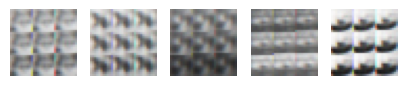

Epoch 2, Loss: 218.0843140234375


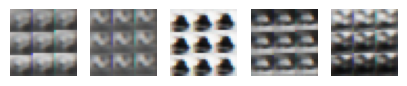

Epoch 3, Loss: 213.1732818359375


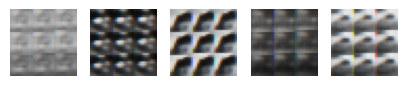

Epoch 4, Loss: 209.034041484375


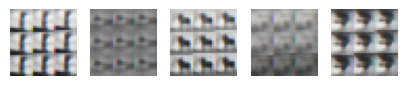

Epoch 5, Loss: 206.86895693359375


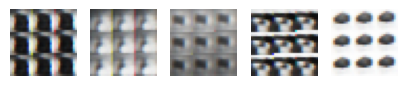

Epoch 6, Loss: 205.4691261328125


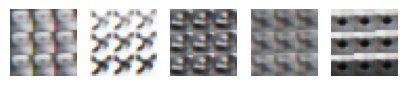

Epoch 7, Loss: 204.4600812109375


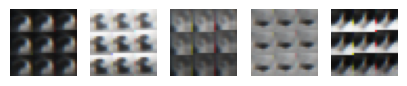

Epoch 8, Loss: 203.5505481640625


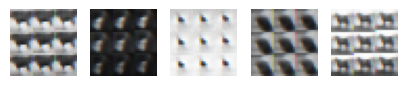

Epoch 9, Loss: 202.90121455078125


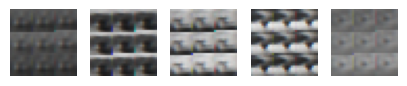

Epoch 10, Loss: 202.286037578125


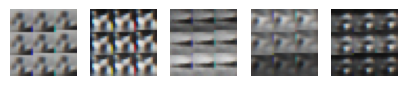

Epoch 11, Loss: 201.84125537109375


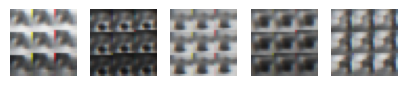

Epoch 12, Loss: 201.28749736328126


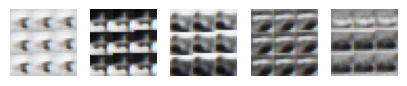

Epoch 13, Loss: 200.8783309765625


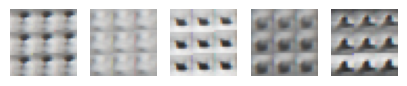

Epoch 14, Loss: 200.6855355078125


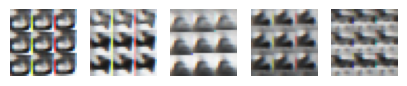

Epoch 15, Loss: 200.2750117578125


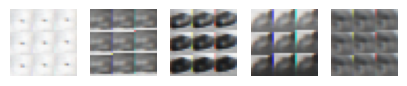

Epoch 16, Loss: 199.795137734375


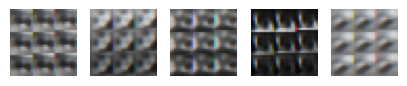

Epoch 17, Loss: 199.51735681640625


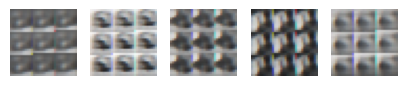

Epoch 18, Loss: 199.3648831640625


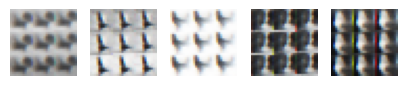

Epoch 19, Loss: 198.954821484375


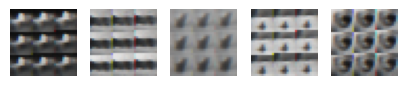

Epoch 20, Loss: 198.63401369140624


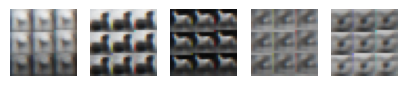

In [7]:
# Hyperparameters
input_dim = 3
hidden_dim = 64
latent_dim = 32
image_size = 32
batch_size = 128
learning_rate = 1e-3
epochs = 20

# Load CIFAR dataset and run the training
# transform = transforms.ToTensor()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

vae = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, image_size=image_size).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

for epoch in range(1, epochs + 1):
    train(vae, train_loader, optimizer, epoch, image_size=image_size)


In [50]:
# Function to generate and display new images
def generate_images(model, num_images=10, latent_dim=20, image_size=32):
    model.eval()  # Set model to evaluation mode
    model.cpu()  # Move the model to CPU for generating images
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()

        # Rescale to [0,1] for plotting with imshow
        scaled_images = (generated_images + 1) / 2

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(scaled_images[i].view(image_size, image_size, 3))
        axs[i].axis('off')
    plt.show()


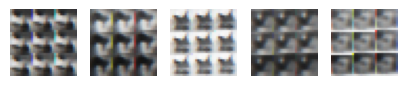

In [9]:
# Assuming you have already trained the model (vae)
generate_images(vae, num_images=5, latent_dim=latent_dim)

(32, 32, 3)


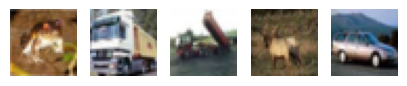

In [10]:
# Plot sample train images
num_images = 5
print(train_dataset.data[0].shape)
fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
for i in range(num_images):
    axs[i].imshow(train_dataset.data[i])
    axs[i].axis('off')
plt.show()

*Analysis:*

The images improve with training as the loss continues to decrease.  Since convolutional layers introduce exponentially more computations in training and each contain 3072 pixel values, large compute power is required to train the model.  This shows a sample concept of how convolutional layers can be implemented with VAEs

Next steps would include large training times and hyperparameter fine tuning at a large scale.  In particular, lowering the learning rate and adjusting hidden_dim and latent_dim variables to 32, 64, 128, and 256.  This optimization would be necessary for stronger recreation of images.

**Task 1 Part B: Fully Connected VAE**

Now we compare the convolutional layered model to a full connected model to show how convolutional layers capture patterns and spatial relationships in the images compared with a basic model.

In [11]:
# Full-connected VAE Architecture with linear layers
class VAE_FC(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_FC, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 1024))
        z = self.reparameterize(mu, logvar)
        return self.decode(z).view(-1, 3, 32, 32), mu, logvar


Files already downloaded and verified
Epoch 1, Loss: 673.061079296875


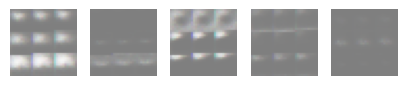

Epoch 2, Loss: 599.6652640625


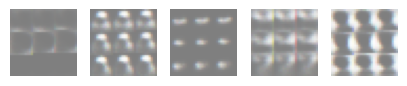

Epoch 3, Loss: 584.581189453125


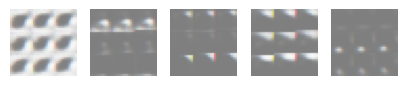

Epoch 4, Loss: 578.53787125


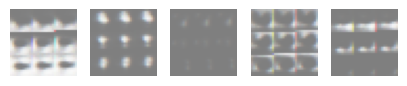

Epoch 5, Loss: 575.261384296875


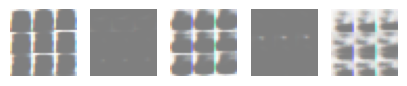

Epoch 6, Loss: 573.210821484375


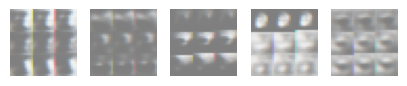

Epoch 7, Loss: 571.589306171875


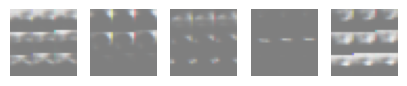

Epoch 8, Loss: 570.425350234375


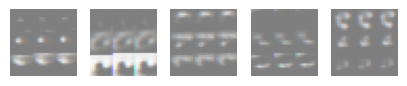

Epoch 9, Loss: 569.51367421875


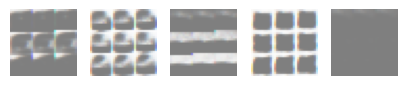

Epoch 10, Loss: 568.729843046875


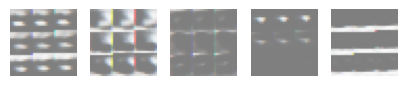

In [13]:
# Load CIFAR dataset and run the training
# transform = transforms.ToTensor()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

vae_fc = VAE_FC(input_dim=1024, hidden_dim=400, latent_dim=20).to(device)
optimizer = optim.Adam(vae_fc.parameters(), lr=1e-3)

for epoch in range(1, 11):
    train(vae_fc, train_loader, optimizer, epoch, image_size=image_size)

Compared to the fully connected layer, the convolutional encoder-decoder architecture shows more promising output, but requires more computational resources for training and is slightly slower to use.  The fully connected layer runs faster, but the images have much less color and do not have as highly-defined features.

**Task 2: Interpolate between images**

Since VAEs generate images by encoding existing images, or sampling from the latent space, we can also simulate transitioning between two images by interpolating across their latent spaces.  To do this, we can encode and reparameterize two images, then use numpy's linspace() function to interpolate between two points in latent space, and then decode these values back into an image.

****

In [38]:
# Interpolate between two images
def interpolate_images(model, image1, image2, num_steps=10):
    model.eval()
    model.cpu()

    with torch.no_grad():
        # Might need to do encode and reparameterize operation on two images
        mu1, log_var1 = model.encode(image1.unsqueeze(0))
        z1 = model.reparameterize(mu1, log_var1)

        mu2, log_var2 = model.encode(image2.unsqueeze(0))
        z2 = model.reparameterize(mu2, log_var2)

        alphas = np.linspace(0, 1, num_steps)
        fig, axs = plt.subplots(1, num_steps, figsize=(num_steps, 1.5))

        for i, alpha in enumerate(alphas):
            z = alpha * z1 + (1 - alpha) * z2
            generated_image = model.decode(z).cpu()

            # Rescale to [0,1] for plotting with imshow
            scaled_image = (generated_image + 1) / 2

             # Plot the generated images
            axs[i].imshow(scaled_image.view(32, 32, 3))
            axs[i].axis('off')

        plt.show()

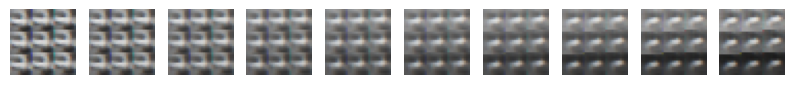

In [39]:
image1, _ = train_dataset[0]
image2, _ = train_dataset[1]

interpolate_images(vae, image1, image2, num_steps=10)

**Task 3: VAE on a new dataset**

Now we train the same VAE model on the CelebA dataset.  This dataset contains 178x218 pixel faces of celebrities.  For the VAE, we will resize these images into a smaller, 64x64 square resolution.


The CelebA training dataset consists of 162770 images, so we will do fewer passes due to compute constraints.

Files already downloaded and verified
Epoch 5, Loss: 834.018035514069


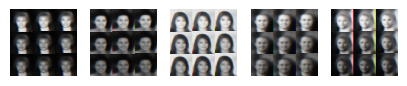

Epoch 5, Loss: 670.4365446642502


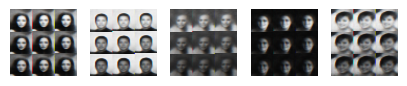

Epoch 5, Loss: 653.920381471939


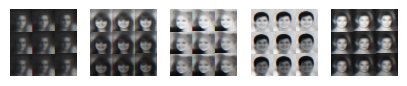

Epoch 5, Loss: 644.0967113536354


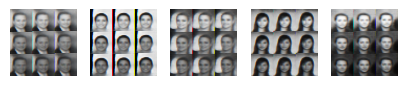

Epoch 5, Loss: 637.494053006159


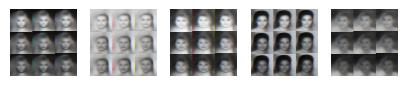

In [48]:
# Hyperparameters
input_dim = 3
hidden_dim = 64
latent_dim = 32
image_size = 64
batch_size = 128
learning_rate = 1e-3
epochs = 5

# Load CelebA dataset and run the training
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
celeb_train_dataset = datasets.CelebA('./data', split='train', download=True, transform=transform)
celeb_train_loader = torch.utils.data.DataLoader(celeb_train_dataset, batch_size=batch_size, shuffle=True)

vae_celeb = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, image_size=image_size).to(device)
celeb_optimizer = optim.Adam(vae_celeb.parameters(), lr=learning_rate)

for epoch in range(1, epochs + 1):
    train(vae_celeb, celeb_train_loader, celeb_optimizer, epochs, image_size=image_size)

*Note: Ignore the epoch labeling mistake in the above results.  Training output is from epochs 1-5.*

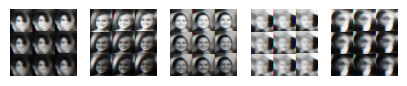

In [51]:
# Assuming you have already trained the model (vae)
generate_images(vae_celeb, num_images=5, latent_dim=latent_dim, image_size=image_size)

*Analysis*

The VAE works very well at higher dimensions with the CelebA dataset.  The convolutional layers focus the model on key features of the image and highlight facial features while the background and hair may get blurred in earlier training.

With larger datasets and high resolution images, this VAE works very well, but requires exponentially more training time due to the complexities of the images and requiring higher dimensions in latent and hidden space to capture them.

We can sample from different regions of the latent space in order to get more similar "classes" of faces depending on what we want out output to look like.